In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt

import gsw as sw

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

In [2]:
# import data directly from myria

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-particle_stats_byfile/data?format=csv'
result = pd.read_csv(fileURL)
# pick out the subset of variables to use for clustering/PCA
print result.columns


Index([u'fsc_avg', u'fsc_var', u'chl_avg', u'chl_var', u'pe_avg', u'pe_var', u'Cruise', u'Day', u'File_Id'], dtype='object')


In [3]:
# load in the SDS data so that we can look at clusters in T/S space and "real" space
# also want to get seasons/months of year for each file

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-all_sds_v2/data?format=csv'
sds = pd.read_csv(fileURL)
sds.rename(columns={'file': 'File_Id', 'day': 'Day'}, inplace=True)
print sds.columns

Index([u'Day', u'LAT', u'LON', u'File_Id', u'T', u'S', u'Cruise'], dtype='object')


In [4]:
# join sds dataframe to cluster results

print sds.shape
#print type(sds), type(cIdx[9])
new_table = pd.merge(sds, result, how="inner")


#X = new_table[['fsc_avg','chl_avg','pe_avg','fsc_var','chl_var','pe_var']].values  
X = new_table[['fsc_avg','chl_avg','pe_avg']].values  

(69235, 7)


In [5]:
# pick a single cruise to work on too
subset = new_table[new_table['Cruise']=='Thompson_1']

In [6]:
# get seasons and join to the sds dataframe
# Get month from the yearday in the file_id\n",
day = (new_table['Day']).tolist()

yd = []

for n in range(0,len(day)):
    yd.append(day[n].split("_")[1])
yd = np.asarray(yd)
yd = yd.astype(np.int)
                           
# length of months
mlen = (31,28,31,30,31,30,31,31,30,31,30,31)
cmlen = np.cumsum(mlen)

month = []
for n in range(0,len(day)):
    if yd[n]<=cmlen[0]:
        month.append(1)
    if yd[n]>cmlen[0] and yd[n]<=cmlen[1]:
        month.append(2)
    if yd[n]>cmlen[1] and yd[n]<=cmlen[2]:
        month.append(3)
    if yd[n]>cmlen[2] and yd[n]<=cmlen[3]: 
        month.append(4)
    if yd[n]>cmlen[3] and yd[n]<=cmlen[4]: 
        month.append(5)
    if yd[n]>cmlen[4] and yd[n]<=cmlen[5]: 
        month.append(6)
    if yd[n]>cmlen[5] and yd[n]<=cmlen[6]:
        month.append(7)
    if yd[n]>cmlen[6] and yd[n]<=cmlen[7]: 
        month.append(8)
    if yd[n]>cmlen[7] and yd[n]<=cmlen[8]:
        month.append(9)
    if yd[n]>cmlen[8] and yd[n]<=cmlen[9]:
        month.append(10)
    if yd[n]>cmlen[9] and yd[n]<=cmlen[10]:
        month.append(11)
    if yd[n]>cmlen[10] and yd[n]<=cmlen[11]: 
        month.append(12)

new_table['month'] = month

season = []
for n in range(0,len(month)):
    if month[n] == 1 or month[n] ==2 or month[n] == 12:
        season.append('winter')
    if month[n] == 3 or month[n] ==4 or month[n] == 5:
        season.append('spring')
    if month[n] == 6 or month[n] ==7 or month[n] == 8:
        season.append('summer')
    if month[n] == 9 or month[n] == 10 or month[n] == 11:
        season.append('fall')
    
new_table['season'] = season

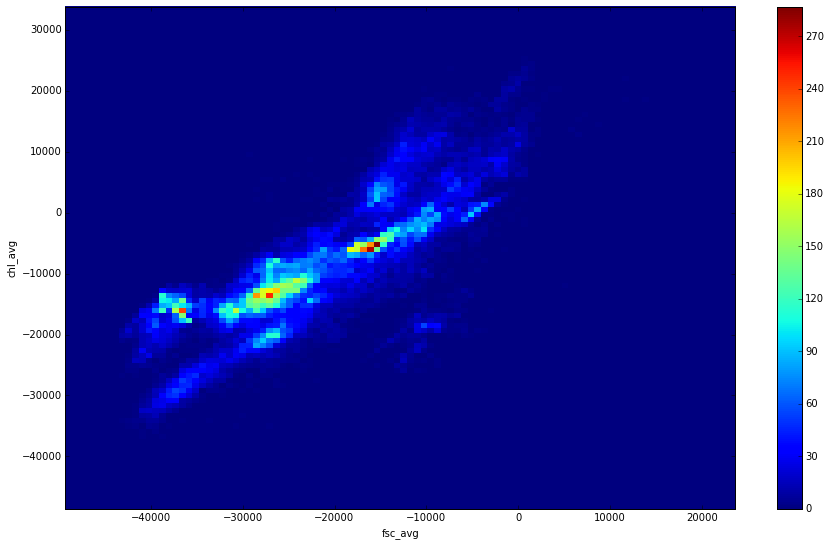

In [7]:
# plot the data to see if it seems to fall into particular clusters right off the bat

fig1 = plt.figure(1, figsize=(15,9))
plt.hist2d(result['fsc_avg'],result['chl_avg'],bins=100, cmap='jet')
plt.xlabel('fsc_avg')
plt.ylabel('chl_avg')
plt.colorbar()
plt.show()

Reduced dataset shape: (37025, 2)


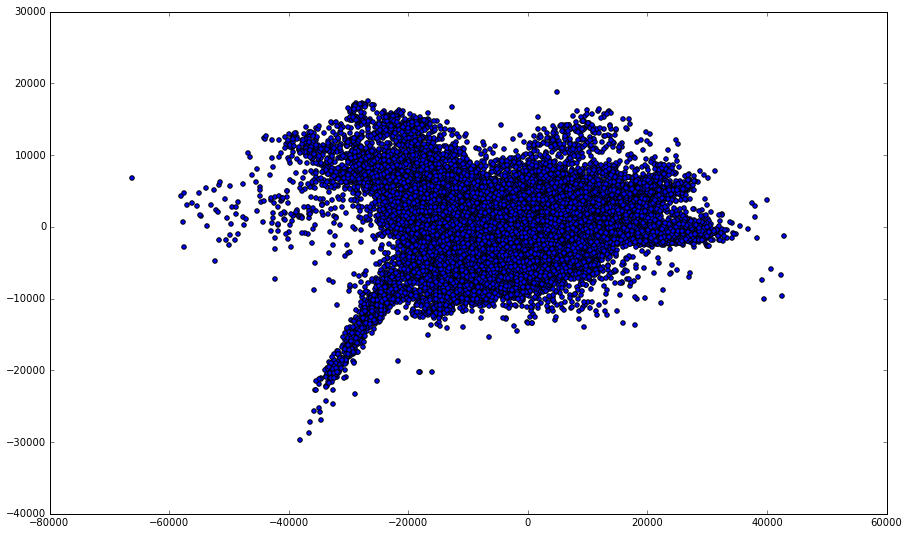

In [8]:
# try doing PCA on the particle statistics
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)
print "Reduced dataset shape:", X_reduced.shape

fig2 = plt.figure(2, figsize=(15,9))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.show()

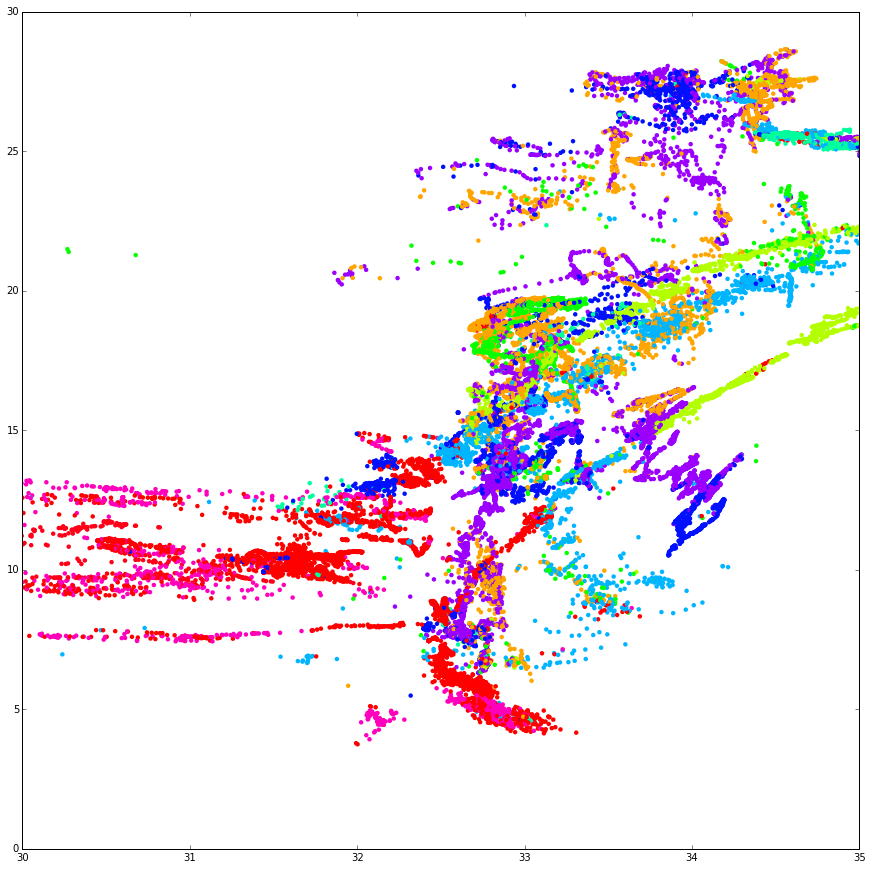

In [9]:
# now try some kind of clustering. 
# start with K-means
k_means = KMeans(n_clusters=10, random_state=0)
k_means.fit(X)
new_table['y_pred'] = k_means.predict(X)


plt.figure(figsize=(15,15))
plt.scatter(new_table['S'],new_table['T'],s=20,c=new_table['y_pred'], linewidth = 0, cmap = 'hsv')

plt.axis([30,35, 0, 30])
plt.show()

In [10]:
# try clustering a single cruise
#subset = new_table[new_table['Cruise']=='Thompson_1']

XX = subset[['fsc_avg','chl_avg','pe_avg']].values 
k_means = KMeans(n_clusters=10, random_state=0)
k_means.fit(XX)
subset['y_pred'] = k_means.predict(XX)

/Users/sclayton/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


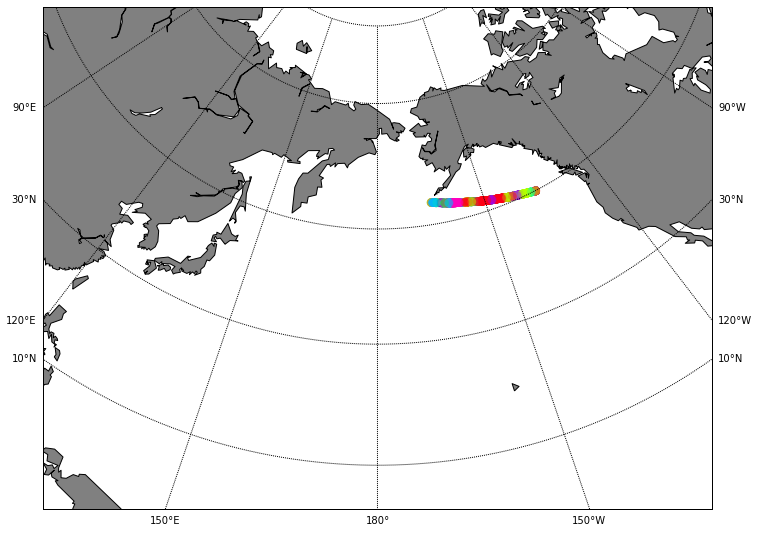

In [11]:
# convert all longitude to longitude east

xb = subset['LON'].values
yb = subset['LAT'].values

xb[xb<0]= 360+xb[xb<0];


xbew = xb

xbew[xbew>180] = xbew[xbew>180]-360

fig1 = plt.figure(1, figsize=(15,9))

m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution='c',lat_1=15.,lat_2=60,lat_0=45,lon_0=-180.)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')
#plt.axes([0.025, 0.025, 0.95, 0.95])
xm, ym = m(xb,yb)
m.scatter(xm, ym, s=75, c=subset['y_pred'], alpha=.5,lw=0, cmap = 'hsv')

m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])


plt.tick_params(axis='both', which='major', labelsize=16)

plt.show()

#print subset['Cruise'].unique()

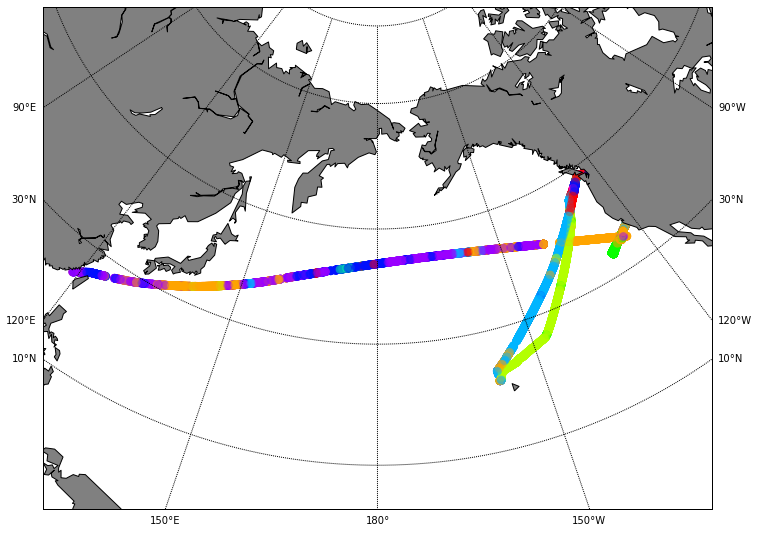

['Thompson_0' 'MBARI_1' 'Tokyo_3' 'Thompson_9' 'Thompson_8' 'Thompson_4']


In [12]:
# convert all longitude to longitude east
subset = new_table[new_table['season']=='fall']

xb = subset['LON'].values
yb = subset['LAT'].values

xb[xb<0]= 360+xb[xb<0];


xbew = xb

xbew[xbew>180] = xbew[xbew>180]-360

fig1 = plt.figure(1, figsize=(15,9))

m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution='c',lat_1=15.,lat_2=60,lat_0=45,lon_0=-180.)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')
#plt.axes([0.025, 0.025, 0.95, 0.95])
xm, ym = m(xb,yb)
m.scatter(xm, ym, s=75, c=subset['y_pred'], alpha=.5,lw=0, cmap= 'hsv')

m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])


plt.tick_params(axis='both', which='major', labelsize=16)

plt.show()
print subset['Cruise'].unique()

In [13]:
#print new_table[['Cruise','group']]
print subset['Cruise'].unique()

['Thompson_0' 'MBARI_1' 'Tokyo_3' 'Thompson_9' 'Thompson_8' 'Thompson_4']


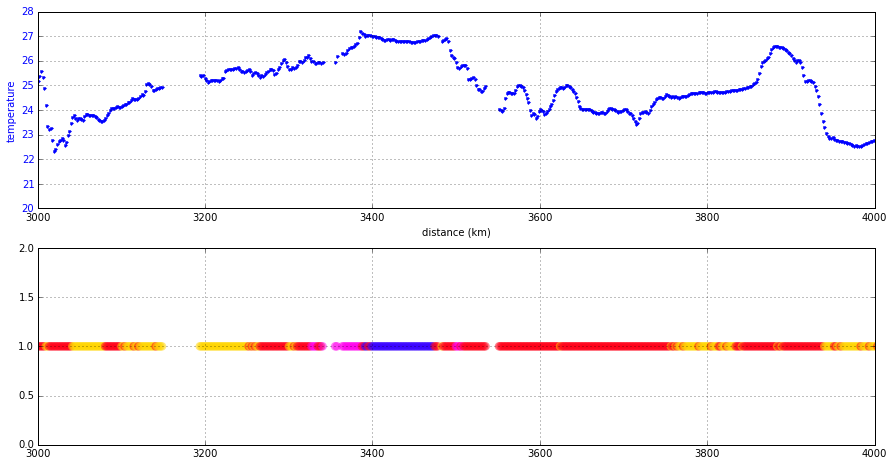

In [14]:
# look at how the clusters relate to physical properties of the water column...

cr = 'Tokyo_3'
crsub = new_table[(new_table['Cruise']==cr)].sort(['Day','File_Id'],ascending=[1,1])
crsub['density'] = sw.rho(crsub['S'].values,crsub['T'].values,0)

cxx = (crsub['LON']).values # longitude
cyy = (crsub['LAT']).values # latitude

# convert all longitude to longitude east
cxx[cxx<0]= 360+cxx[cxx<0];
cxbew = cxx
cxbew[cxbew>180] = cxbew[cxbew>180]-360

# calculate distance between points
cdistance = sw.distance(cxbew,cyy, 0)[0]
ctrack = np.cumsum(cdistance)
ctrack = np.insert(ctrack, 0, 0)

# set the limits on the y axis
trmin = 3000
trmax = 4000

fig2 = plt.figure(figsize=(15,12))

ax1 = fig2.add_subplot(3, 1, 1)
#ax2 = fig2.add_subplot(3,1, 2)
ax3 = fig2.add_subplot(3,1, 2)

ax1.plot(ctrack/1000, crsub['T'],'.b')
ax1.set_xlabel('distance (km)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('temperature', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_ylim(20,28)
ax1.set_xlim(trmin,trmax)
ax1.grid(True)

#ax2.plot(ctrack/1000, crsub['density']-1000, '.r')
#ax2.set_ylabel('density', color='r')
#for tl in ax2.get_yticklabels():
#    tl.set_color('r')
#ax2.grid(True)
#ax2.set_ylim(20,25)
#ax2.set_xlim(trmin,trmax)

ax3.scatter(ctrack/1000,np.ones(len(crsub['y_pred'])),s=75, c=crsub['y_pred'], alpha=.5,lw=0, cmap= 'hsv')
ax3.grid(True)
ax3.set_ylim(0,2)
ax3.set_xlim(trmin,trmax)
plt.show()

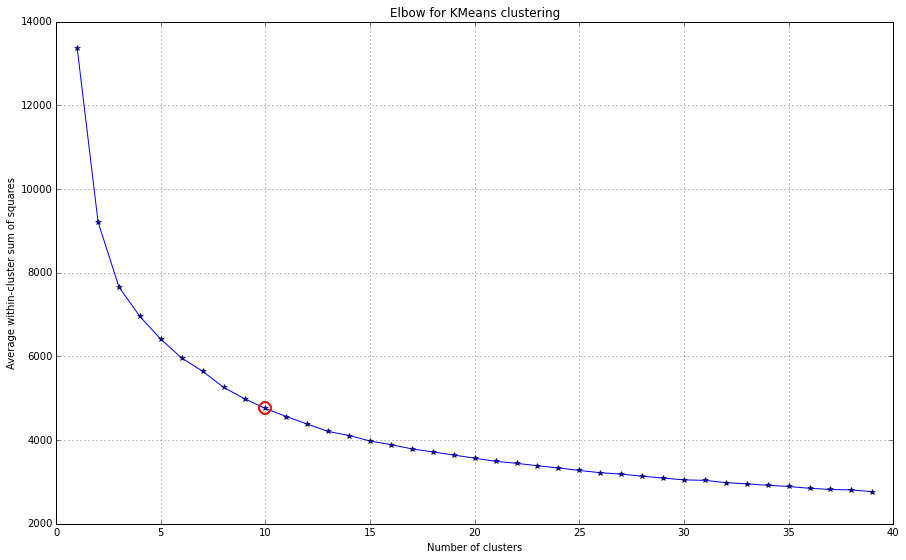

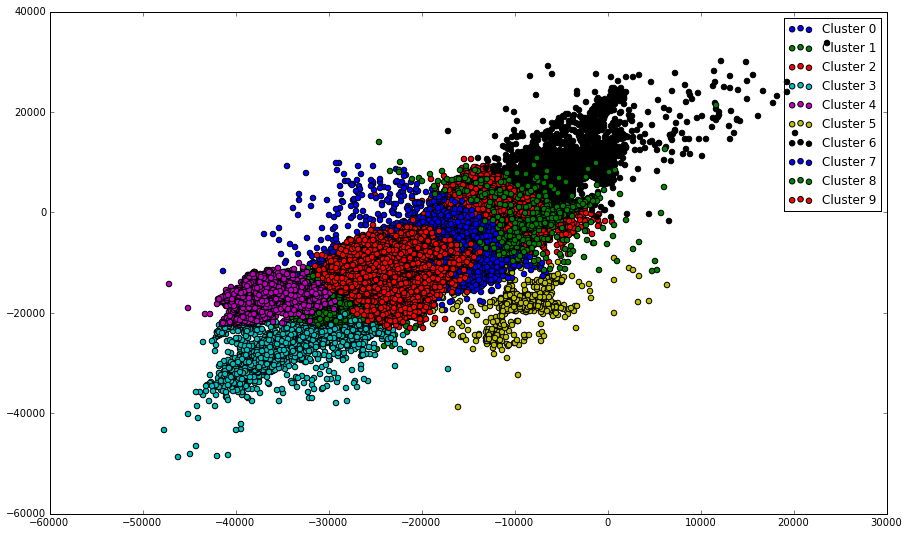

In [15]:
# try hierarchical clustering on the data
# do not have to specify number of clusters

from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist

# Start by estimating optimal number of clusters
# uses method from this website: 
# http://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means
K = range(1,40)

# scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
#avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

# alternative: scipy.spatial.distance.cdist
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

##### plot ###
kIdx = 9

# elbow curve
fig4 = plt.figure(4, figsize=(15,9))
ax = fig4.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

# scatter plot
fig5 = plt.figure(5, figsize=(15,9))
ax = fig5.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
clr = ['b','g','r','c','m','y','k','b','g','r']
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(X[ind,0],X[ind,1], s=30, c=clr[i], label='Cluster %d'%i)
plt.legend()
plt.show()